In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Loading the river flow (discharge) data

In [2]:
def get_yearly_flow(year=2016):
    """ Reading text files with yearly data.
    """
    flow_df = pd.read_csv(f'data/hourly_flows_2016-19/flows-{year}.txt', delimiter='\t').drop(columns='V')
    flow_df.columns = ['datetime', 'discharge']
    flow_df['datetime'] = pd.to_datetime(flow_df['datetime'], dayfirst=True)
    flow_df = flow_df.set_index('datetime')
    return flow_df

In [17]:
def get_combined_flow():
    """ Combining dataframes from individual years into one dataframe.
    """
    dfs = []
    for year in range(2016, 2020):
        dfs.append(get_yearly_flow(year=year))
    return pd.concat(dfs)
        

In [18]:
flow_df = get_combined_flow()

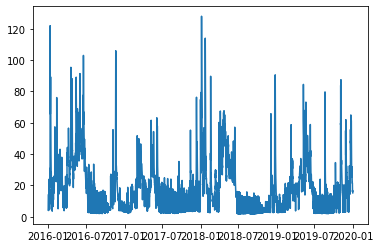

In [19]:
plt.plot(flow_df.index, flow_df)

In [20]:
flow_df.to_csv('data/hourly_flows_2016-19.csv')

### Exploratory Analysis

In [21]:
subset_df = flow_df.loc[:]
subset_df['year'] = subset_df.index.year
subset_df['offset_datetime'] = subset_df.index + pd.DateOffset(year=2019)

/home/mnolte/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:692: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


In [22]:
sns.set(style="whitegrid")

Text(0, 0.5, 'Discharge (m^3/s)')

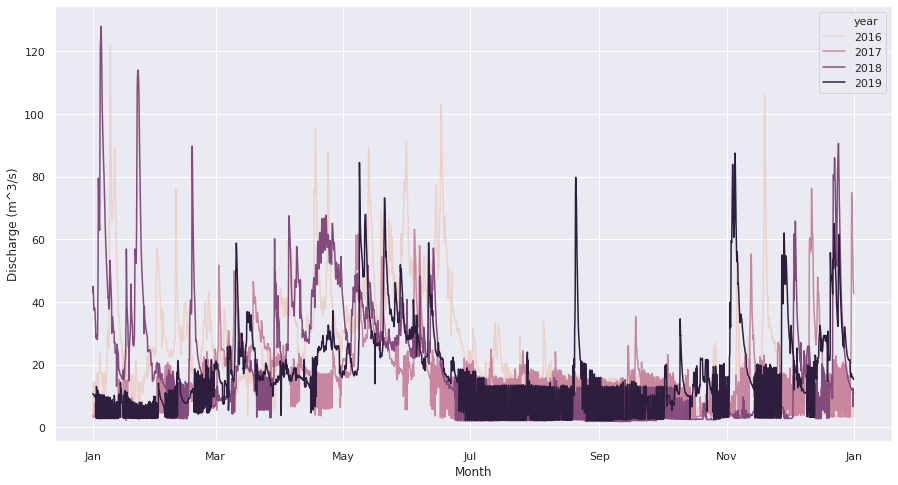

In [23]:
sns.set(rc={'figure.figsize':(15, 8)})
ax = sns.lineplot(x='offset_datetime', y='discharge', hue='year', data=subset_df, markers='')
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')
ax.get_xaxis().set_major_formatter(myFmt)
ax.set_xlabel('Month')
ax.set_ylabel('Discharge (m^3/s)')

### Simple time series forecasting

In [25]:
import statsmodels.api as sm

In [26]:
train = flow_df.loc[flow_df.index < pd.to_datetime('2019-01-01 00:00:00')]
test = flow_df.loc[(flow_df.index >= pd.to_datetime('2019-01-01 00:00:00')) & (flow_df.index < pd.to_datetime('2019-07-01 00:00:00'))]

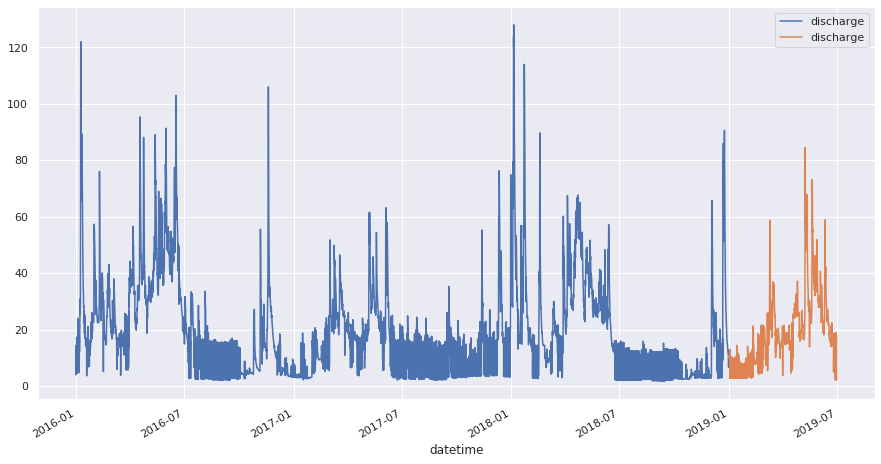

In [27]:
fig, ax = plt.subplots()
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.legend()
plt.show()

### SARIMA modelling

In [28]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [57]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        from kaggle
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        t_statistic, p_value = sm.tsa.stattools.adfuller(y)[:2]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

#### Taking into account seasonality

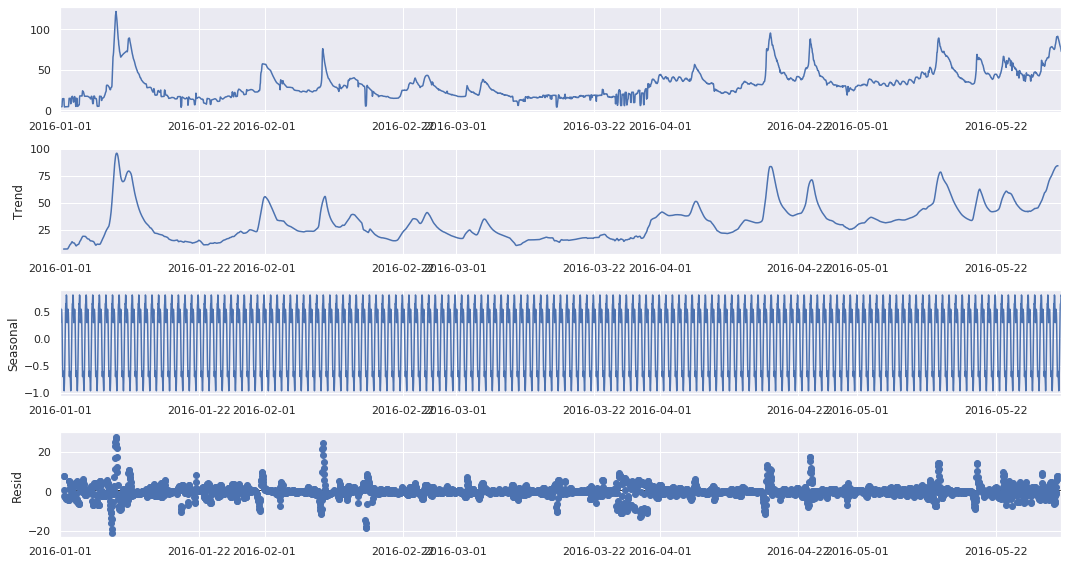

In [58]:
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
decomp = seasonal_decompose(flow_df.loc[flow_df.index < pd.to_datetime('2016-06-01 00:00:00')], 
                            period=24)

# Plot decomposition
decomp.plot()
plt.show()

#### Augmenteded Dicky-Fuller to check for stationarity


In [59]:
flow = flow_df['discharge']
flow_diff_1 = (flow - flow.shift(1)).dropna()
flow_diff_1_24 = (flow_diff_1 - flow_diff_1.shift(24)).dropna()
flow_diff_24 = (flow - flow.shift(24)).dropna()

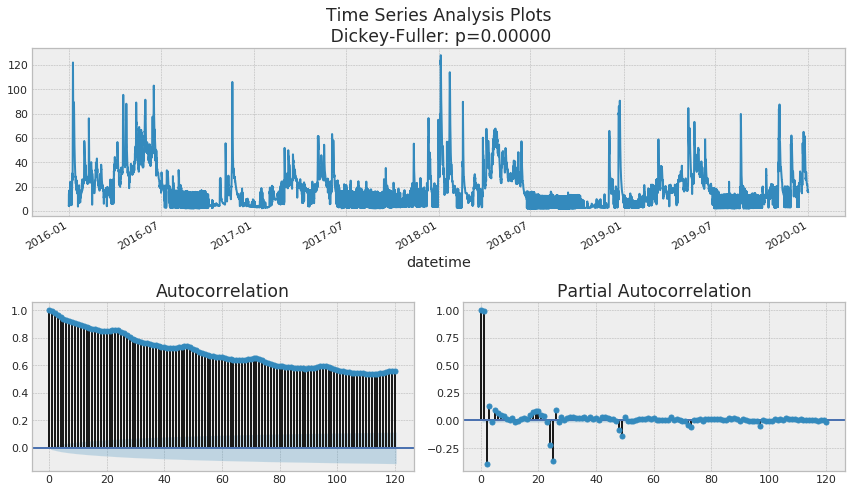

In [61]:
 tsplot(flow, lags=24*5, figsize=(12, 7))

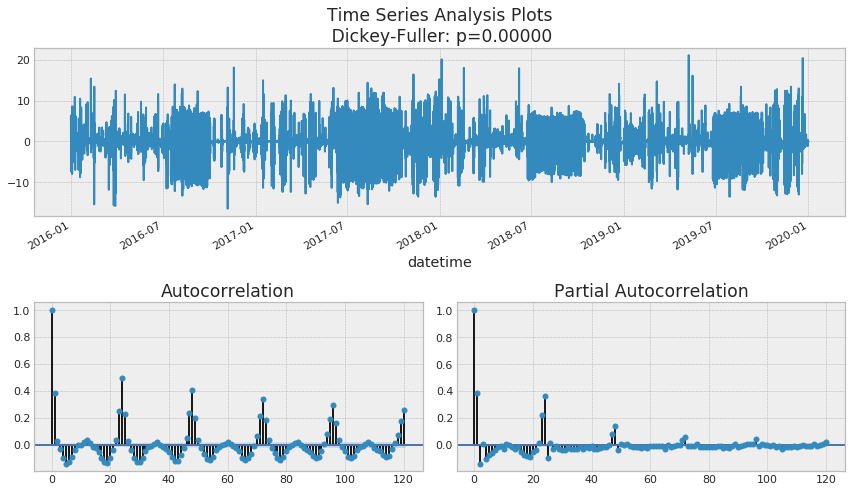

In [62]:
 tsplot(flow_diff_1, lags=24*5, figsize=(12, 7))

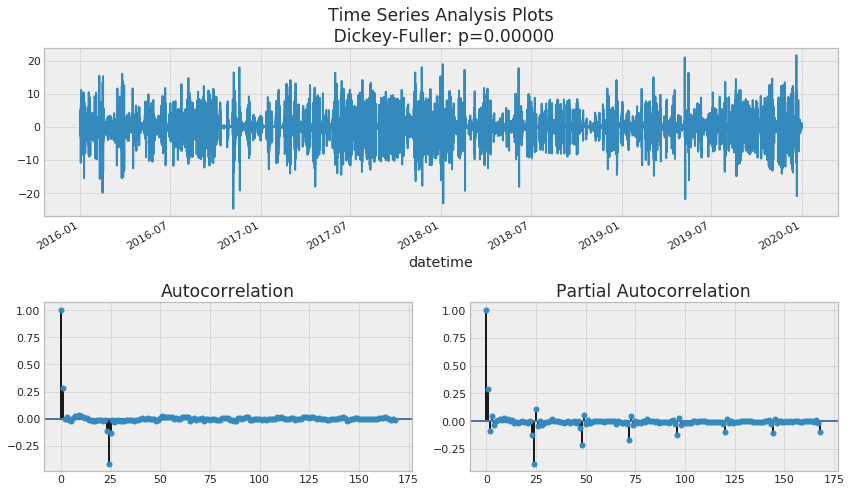

In [71]:
 tsplot(flow_diff_1_24, lags=24*7, figsize=(12, 7))

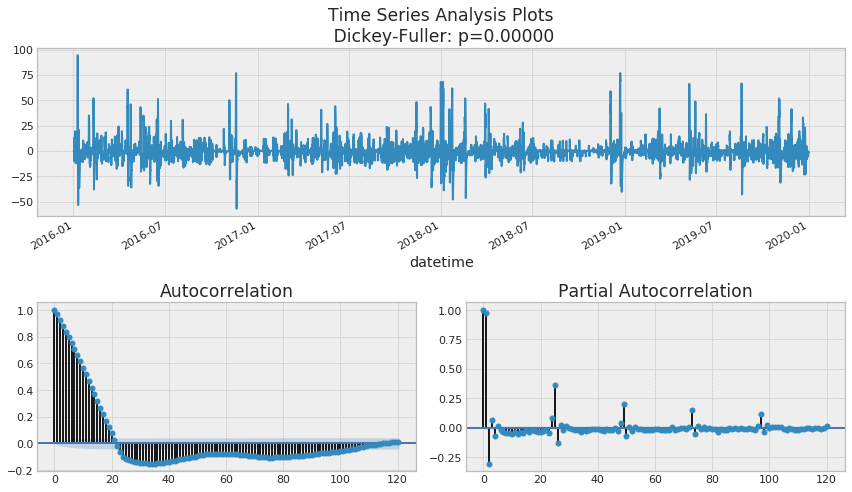

In [64]:
 tsplot(flow_diff_24, lags=24*5, figsize=(12, 7))

#### Fitting SARIMAX

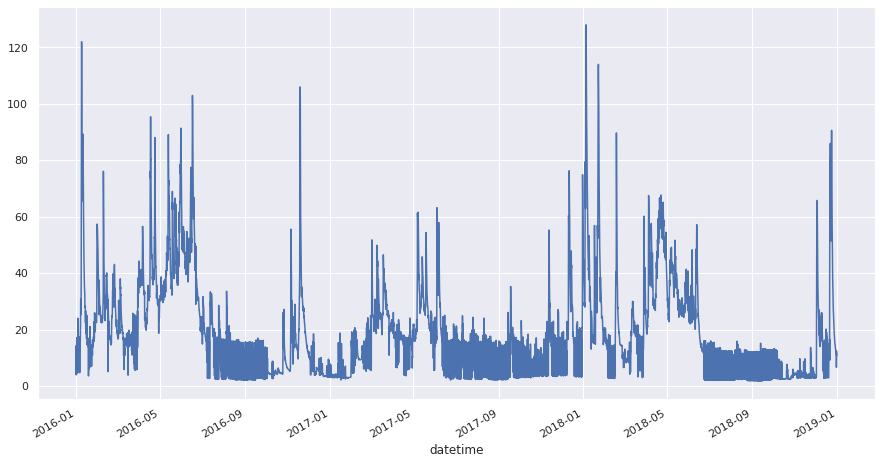

In [104]:
train['discharge'].plot()

In [ ]:
### Crashed again upon completion, make sure the time series is ok

# Create a SARIMAX model
model = SARIMAX(train['discharge'], order=(2,1,1), seasonal_order=(3,1,1,24))
# p - 2 or 4; q is cleary one. Q is clearly 1, P is tapering off.. maybe 3 or 4?

# Fit the model
results = model.fit()

# Print the results summary
print(results.summary())

In [3]:
results

NameError: name 'results' is not defined

#### Plotting the forecast

In [82]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-48)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower discharge']
upper_limits = confidence_intervals.loc[:, 'upper discharge']


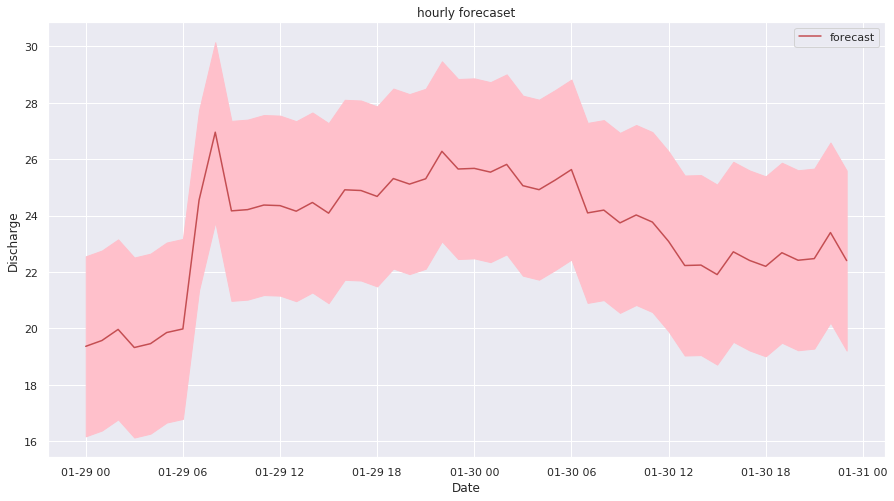

In [83]:
# plot the dranse data

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('hourly forecaset')
plt.legend()
plt.show()

In [101]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-4, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int(alpha=0.05) # 95 percent confidence interval

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower discharge']
upper_limits = confidence_intervals.loc[:,'upper discharge']


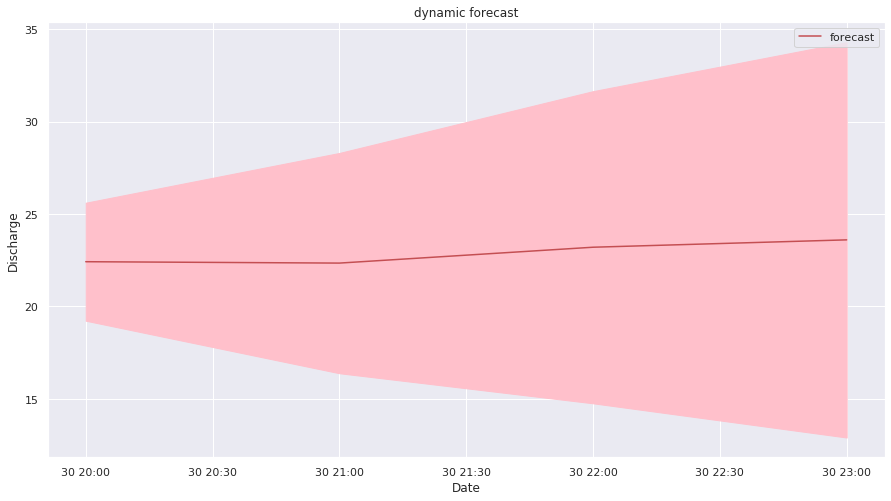

In [102]:
# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('dynamic forecast')
plt.legend()

#### Finding the best model manually

In [ ]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(0, 12, 2):
  # Loop over q values from 0-2
    for q in range(0, 12, 2):
        print(p, q)
      	# create and fit ARMA(p,q) model
        model = SARIMAX(flow_diff, order=(p,0,q))
        results = model.fit();
        
        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))

In [ ]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

In [ ]:
# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

# Print summary
print(results.summary())

### Using automated model selection

In [38]:
import pmdarima as pm

In [ ]:
# Create model for SARIMAX(p,1,q)(P,1,Q)7
model3 = pm.auto_arima(df3,
                      seasonal=True, m=7,
                      d=1, D=1, 
                      start_p=1, start_q=1,
                      max_p=1, max_q=1,
                      max_P=1, max_Q=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

# Print model summary
print(model3.summary())

In [ ]:
# Import joblib
import joblib

# Set model name
filename = "candy_model.pkl"

# Pickle it
joblib.dump(model, filename)